In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import os

SHIFT_START = 2000
CAPTURE     = 5000

# https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
def read_wav(wav_file_name):
    sr, signal = wavfile.read(wav_file_name)
    return (sr, signal[SHIFT_START:(SHIFT_START + CAPTURE), 0]) # use the first channel (or take their average, alternatively)

def fetch_frequencies(wav_file_name):
    sr, y = read_wav(wav_file_name)
    return y

def show_frequency_spectrum(wav_file_name):
    sr, y = read_wav(wav_file_name)
    t = np.arange(len(y)) / float(sr)

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, y)
    plt.xlabel('t')
    plt.ylabel('y')
    axes = plt.gca()
    axes.set_ylim([-1e9, 1e9])

    plt.show()

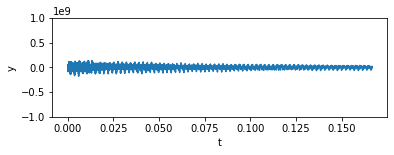

In [12]:
SAMPLES_DIR = 'samples'
TRAIN_DIR = 'train'
TEST_DIR = 'test'

show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'A', TRAIN_DIR, '1_out_of_tune', 'splitted_chord009.wav'))

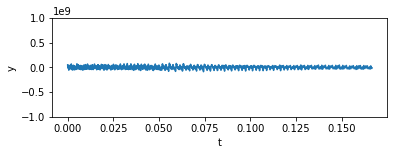

In [13]:
show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'C', TRAIN_DIR, '1', 'splitted_chord007.wav'))

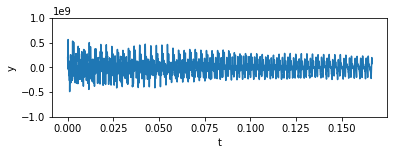

In [14]:
show_frequency_spectrum(os.path.join(SAMPLES_DIR, 'E', TRAIN_DIR, '1', 'splitted_chord007.wav'))

In [15]:
def files_to_tensors(files):
    return tf.convert_to_tensor([tf.convert_to_tensor(fetch_frequencies(file), np.int32) for file in files])

In [16]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(CAPTURE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
import glob
import itertools

def parse_sound_name(path):
    sound_folders_depth = 1
    return os.path.normpath(path).split(os.path.sep)[sound_folders_depth]

sound_names_files = {}
for sound_dir in glob.glob(os.path.join(SAMPLES_DIR, '*')):
    sound_files_mask = os.path.join(sound_dir, TRAIN_DIR, '*', '*.wav')
    sound_names_files[parse_sound_name(sound_dir)] = glob.glob(sound_files_mask)

sound_names_index = {sound_name: idx for idx, sound_name in enumerate(sound_names_files.keys())}
sound_names_index_reverted = {v: k for k, v in sound_names_index.items()}
print('Following sounds are going to be categorized')
print(list(sound_names_index.keys()))

sound_files = list(itertools.chain.from_iterable(sound_names_files.values()))
train_labels = [[sound_names_index[sound_name]] * len(files) for sound_name, files in sound_names_files.items()]
train_labels = tf.convert_to_tensor(list(itertools.chain.from_iterable(train_labels)))
train_files_data = files_to_tensors(sound_files)

Following sounds are going to be categorized
['A', 'C', 'E']


In [18]:
model.fit(train_files_data, train_labels, epochs=5)

Train on 93 samples
Epoch 1/5
93/93 [==============================] - 25s 269ms/sample - loss: 5808744381.9355 - accuracy: 0.4086
Epoch 2/5
93/93 [==============================] - 4s 45ms/sample - loss: 1575223956.6452 - accuracy: 0.7527
Epoch 3/5
93/93 [==============================] - 4s 40ms/sample - loss: 206349799.9140 - accuracy: 0.9247
Epoch 4/5
93/93 [==============================] - 4s 40ms/sample - loss: 451362802.2366 - accuracy: 0.9462
Epoch 5/5
93/93 [==============================] - 4s 38ms/sample - loss: 27466714.4946 - accuracy: 0.9892


In [19]:
def predict_files(files):
    print()
    files_data = files_to_tensors(files)
    correct_predictions = 0
    for idx, prediction in enumerate(model.predict(files_data)):
        sound_name = sound_names_index_reverted[list(prediction).index(1)]
        print(f'{sound_name} - {files[idx]}')
        if parse_sound_name(files[idx]) == sound_name:
            correct_predictions += 1
    print('=' * 10)
    print(f'Prediction success rate: {round(correct_predictions / len(files) * 100, 2)}%')
    print()

test_files = glob.glob(os.path.join(SAMPLES_DIR, '*', TEST_DIR, '*', '*.wav'))
predict_files(test_files)


A - samples/A/test/1_out_of_tune/splitted_chord001.wav
A - samples/A/test/1_out_of_tune/splitted_chord003.wav
A - samples/A/test/1_out_of_tune/splitted_chord002.wav
C - samples/C/test/2/splitted_chord001.wav
C - samples/C/test/2/splitted_chord003.wav
C - samples/C/test/2/splitted_chord002.wav
E - samples/C/test/2/splitted_chord004.wav
C - samples/C/test/1/splitted_chord001.wav
C - samples/C/test/1/splitted_chord003.wav
C - samples/C/test/1/splitted_chord002.wav
E - samples/E/test/1/splitted_chord001.wav
E - samples/E/test/1/splitted_chord005.wav
E - samples/E/test/1/splitted_chord002.wav
E - samples/E/test/1/splitted_chord004.wav
Prediction success rate: 92.86%



In [20]:
predict_files([os.path.join(SAMPLES_DIR, 'A', TRAIN_DIR, '1_out_of_tune', 'splitted_chord009.wav')])


A - samples/A/train/1_out_of_tune/splitted_chord009.wav
Prediction success rate: 100.0%

